# Introduction

> Have you ever wondered if 99% accuracy on a model is good? The answer is simple but complicated: Maybe not! In this notebook we'll cover why looking only at accuracy metrics is dangerous, and we'll show other metrics that can contribute to your model evaluation.

> For this, we are going to use a Credit Card Transactions dataset, with the objective to identify fraudulent transactions. First we'll cover the setup, by checking the data, then we'll do an Exploratory Data Analysis (EDA), to identify possible patterns and insights to use as features in our model, aswell as identify needed transformations. After that, we'll do the feature engineering, by using scaling and categorical encoding. Then we'll cover Undersampling and its importance, and then check the feature importances. Finally but not least important, we'll prepare our validation and test datasets to train, tune and evaluate our models!

## Libraries Used

In [416]:
#Basic libraries
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import math
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

#Sampling methods
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

#feature engineering
import datetime as dt
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler

#Feature Selection
from boruta import BorutaPy

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

#Hyperparameter tuning
from skopt import gp_minimize

#Model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn import metrics
import scipy.stats as stats
from scipy.stats import skew

## Importing Data

In [417]:
train = pd.read_csv(r"data\fraudTrain.csv", index_col=0)
pd.options.display.float_format = '{:,.2f}'.format

## Data Cleansing

First we'll have a look at our data.

In [418]:
train.head(3)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.15,-112.15,0


In [419]:
train.shape

(1296675, 22)

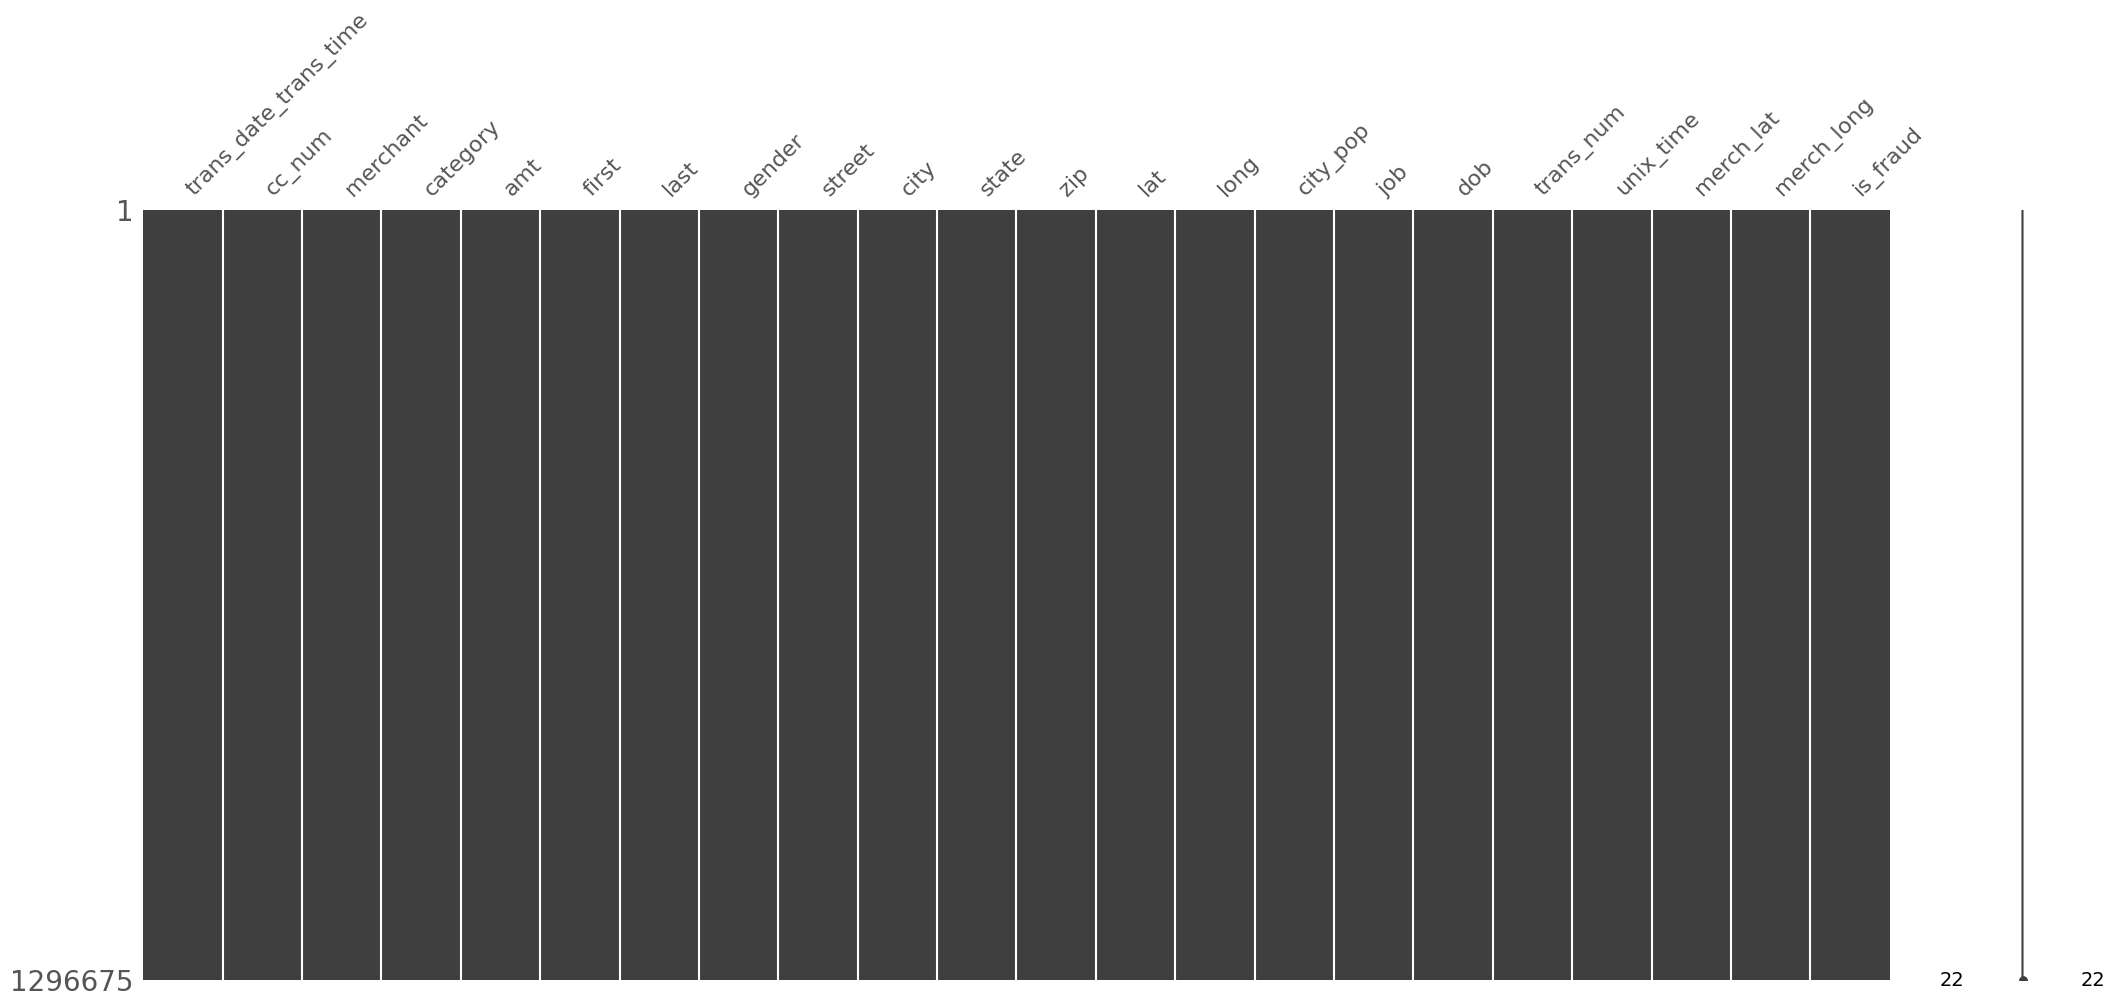

In [420]:
msno.matrix(train);

In [421]:
train.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

As we can see, there is no missing values!

# Exploratory Data Analysis (EDA)

In [422]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_num,"1,296,675.00","417,192,042,079,726,656.00","1,308,806,447,000,240,384.00","60,416,207,185.00","180,042,946,491,150.00","3,521,417,320,836,166.00","4,642,255,475,285,942.00","4,992,346,398,065,154,048.00"
amt,"1,296,675.00",70.35,160.32,1.00,9.65,47.52,83.14,"28,948.90"
zip,"1,296,675.00","48,800.67","26,893.22","1,257.00","26,237.00","48,174.00","72,042.00","99,783.00"
lat,"1,296,675.00",38.54,5.08,20.03,34.62,39.35,41.94,66.69
long,"1,296,675.00",-90.23,13.76,-165.67,-96.80,-87.48,-80.16,-67.95
city_pop,"1,296,675.00","88,824.44","301,956.36",23.00,743.00,"2,456.00","20,328.00","2,906,700.00"
unix_time,"1,296,675.00","1,349,243,636.73","12,841,278.42","1,325,376,018.00","1,338,750,742.50","1,349,249,747.00","1,359,385,375.50","1,371,816,817.00"
merch_lat,"1,296,675.00",38.54,5.11,19.03,34.73,39.37,41.96,67.51
merch_long,"1,296,675.00",-90.23,13.77,-166.67,-96.90,-87.44,-80.24,-66.95
is_fraud,"1,296,675.00",0.01,0.08,0.00,0.00,0.00,0.00,1.00


In [423]:
train["amt"].describe()

count   1,296,675.00
mean           70.35
std           160.32
min             1.00
25%             9.65
50%            47.52
75%            83.14
max        28,948.90
Name: amt, dtype: float64

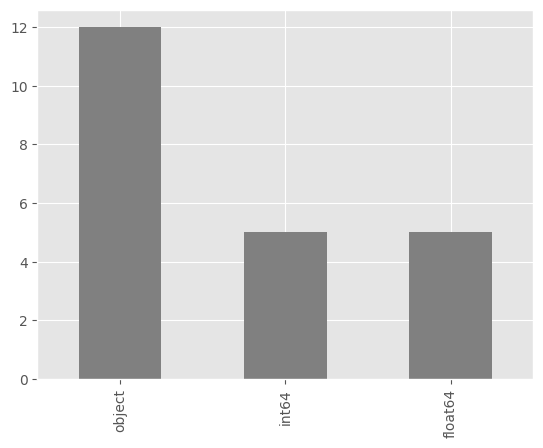

In [424]:
train.dtypes.value_counts().plot(kind='bar', color="grey");

There are a lot of categorical features! So we are probably going to consider categorical encoding.

## Univariate analysis

Lets check the target imbalance!

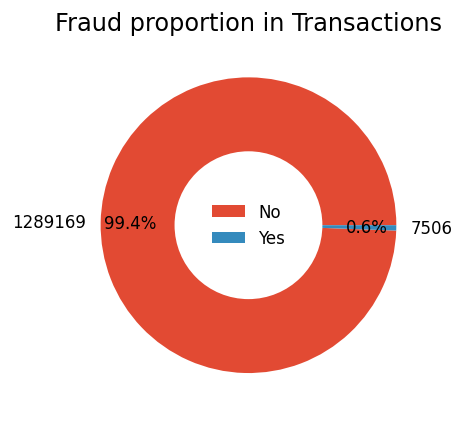

In [425]:
donut = train["is_fraud"].value_counts().reset_index()

labels = ["No", "Yes"]
explode = (0, 0)

fig, ax = plt.subplots(dpi=120, figsize=(8, 4))
plt.pie(donut["is_fraud"],
        labels=donut["is_fraud"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=explode)

centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Fraud proportion in Transactions")
plt.legend(labels, loc="center", frameon=False)
plt.show();

We have a severe imbalance dataset. Because of this, Oversampling/Undersampling will be considered in the model.

Let's check the distribution of the amount ("amt") feature.

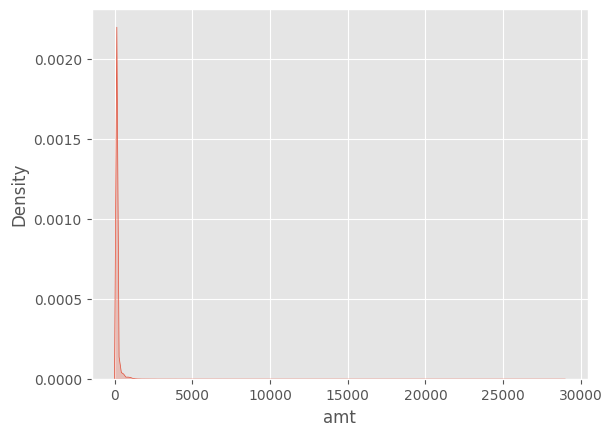

In [426]:
sns.kdeplot(train["amt"], fill=True);

Higher values of amount is distorting the graph. So we fix it plotting only 0-99% of amount.

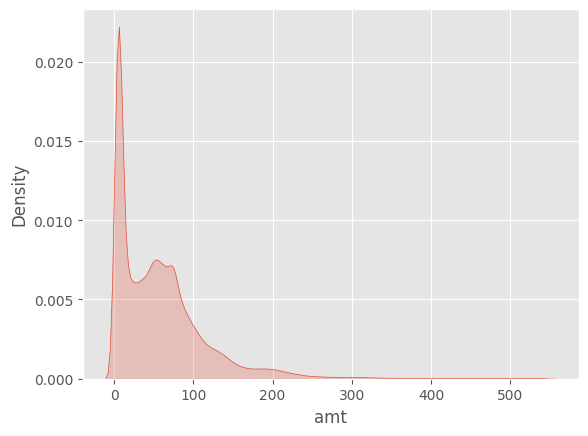

In [427]:
p99 = train["amt"].quantile(0.99)
sns.kdeplot(x="amt", data=train[train["amt"] <= p99], fill=True);

Lets se if there is any noticeable pattern between the target (is_fraud) and amount.

## Multivariate analysis

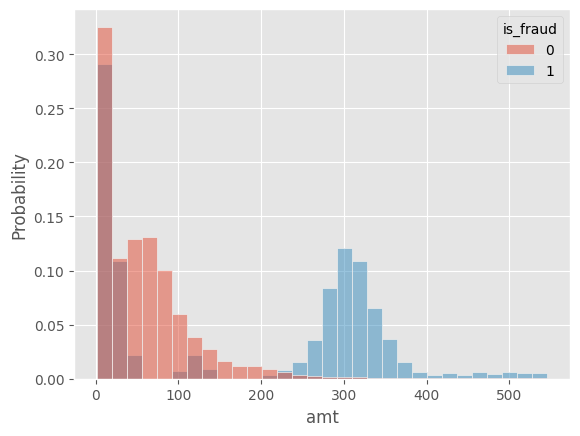

In [428]:
p99 = train["amt"].quantile(0.99)
sns.histplot(x="amt", hue="is_fraud", bins=30,
             stat="probability", data=train[train["amt"] <= p99],
             common_norm=False);

Notice that the probability distribution behaves differently for each value of "is_fraud".

We can expand this analysis to each transaction category:

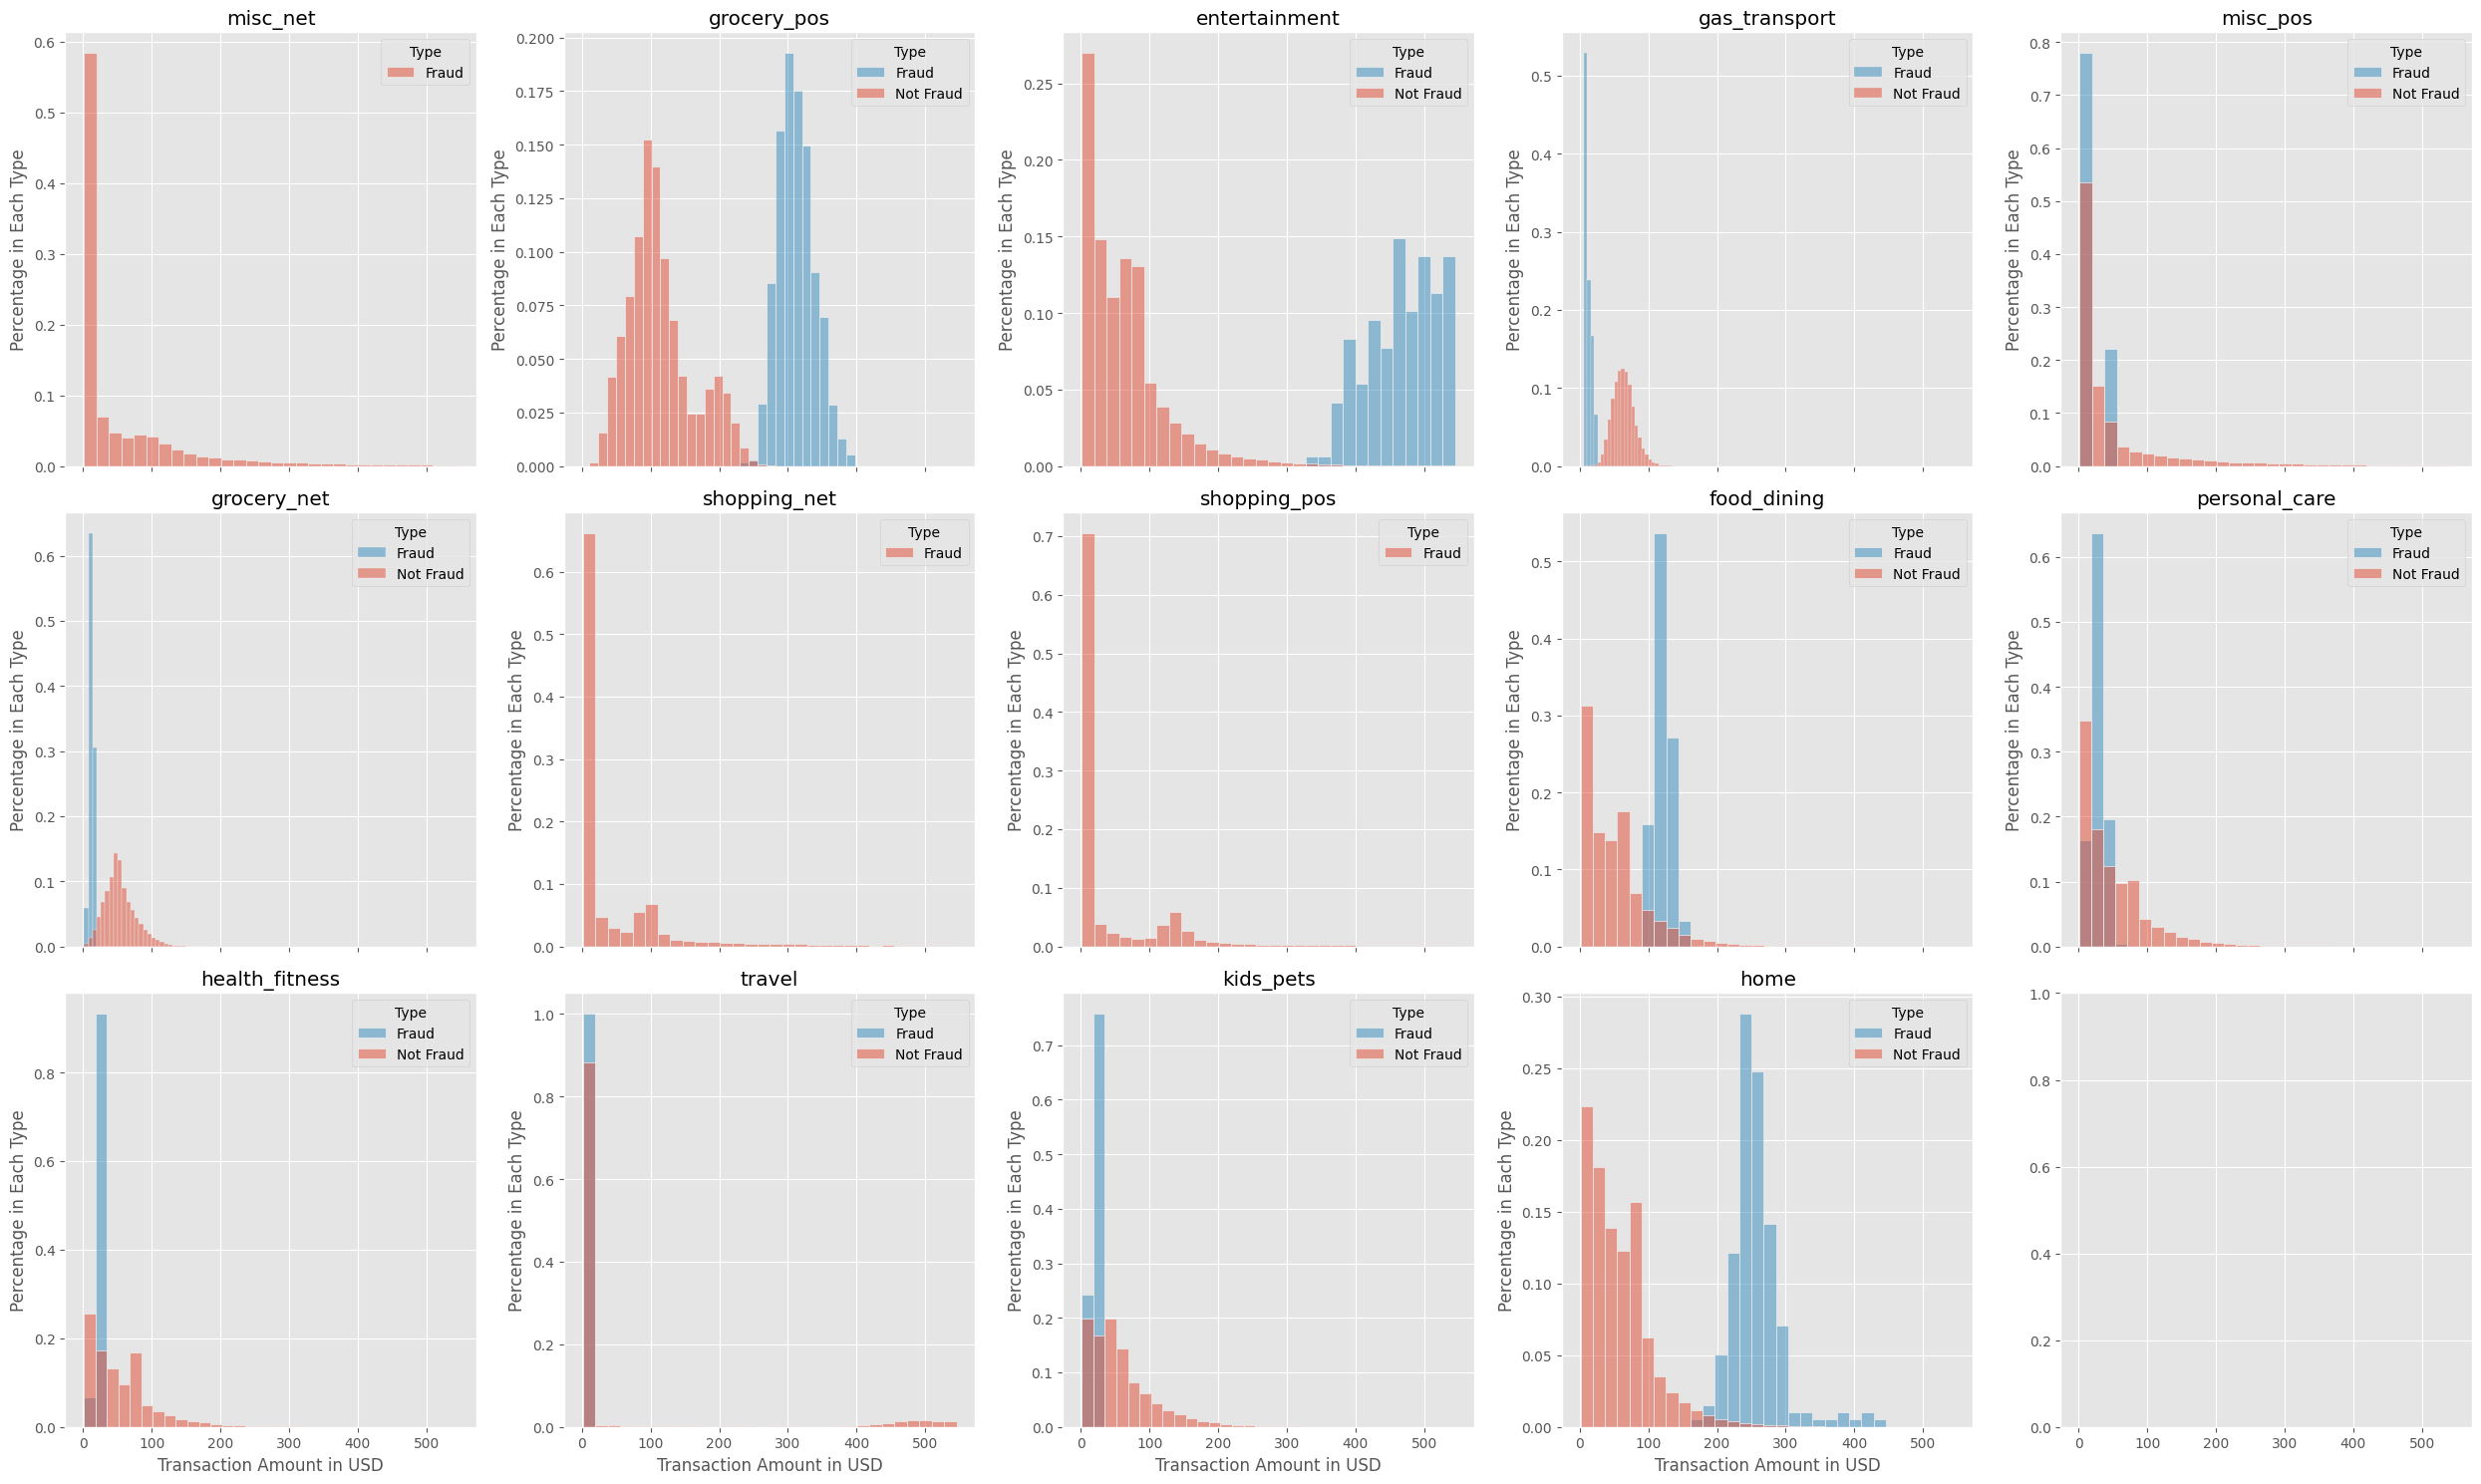

In [429]:
categories = train['category'].unique()

num_plots = len(categories)
num_rows = math.isqrt(num_plots)
num_cols = math.ceil(num_plots / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(
    5*num_cols, 5*num_rows), sharex=True)

for i, category in enumerate(categories):

    row = i // num_cols
    col = i % num_cols

    data_category = train[train['category'] == category]

    if num_rows == 1 and num_cols == 1:
        ax = axes
    elif num_rows == 1 or num_cols == 1:
        ax = axes[i]
    else:
        ax = axes[row, col]

    sns.histplot(x='amt', data=data_category[data_category['amt'] <= p99],
                 hue='is_fraud', stat='probability',
                 common_norm=False, bins=30, ax=ax)

    ax.set_ylabel('Percentage in Each Type')
    ax.set_xlabel('Transaction Amount in USD')
    ax.set_title(f'{category}')
    ax.legend(title='Type', labels=['Fraud', 'Not Fraud'])

plt.tight_layout()

plt.show();

Lets dive into categories. We'll analyze which categories the frauds are more frequently. For this, we'll calculate the distribution for each category for normal transactions and then the distribution for fraudulents transactions. Then, we take the difference between the two distributions. This difference shows us the categories that are most predominants to have frauds.

In [430]:
# non_fraud
non_fraud = train[train['is_fraud'] == 0]['category'].value_counts(
    normalize=True).to_frame().reset_index()
non_fraud.columns = ['category', 'not_fraud_percentual_vs_total']

# fraud
fraud = train[train['is_fraud'] == 1]['category'].value_counts(
    normalize=True).to_frame().reset_index()
fraud.columns = ['category', 'fraud_percentage_vs_total']

# merging two dataframes and calculating "fraud level"
non_fraud_vs_fraud = non_fraud.merge(fraud, on='category')
non_fraud_vs_fraud['fraud_level'] = non_fraud_vs_fraud['fraud_percentage_vs_total'] - \
    non_fraud_vs_fraud['not_fraud_percentual_vs_total']

non_fraud_vs_fraud

,category,not_fraud_percentual_vs_total,fraud_percentage_vs_total,fraud_level
0,gas_transport,0.10,0.08,-0.02
1,home,0.10,0.03,-0.07
2,grocery_pos,0.09,0.23,0.14
3,shopping_pos,0.09,0.11,0.02
4,kids_pets,0.09,0.03,-0.06
5,shopping_net,0.07,0.23,0.15
6,entertainment,0.07,0.03,-0.04
7,food_dining,0.07,0.02,-0.05
8,personal_care,0.07,0.03,-0.04
9,health_fitness,0.07,0.02,-0.05


Note that the columns "not_fraud_percentual_vs_total" and "fraud_percentage_vs_total" sums up to 1. That's because we are taking the percentual of each category on total, for fraud and not fraud, and calculating the "fraud_level" metric, that shows which category is more common to have frauds.

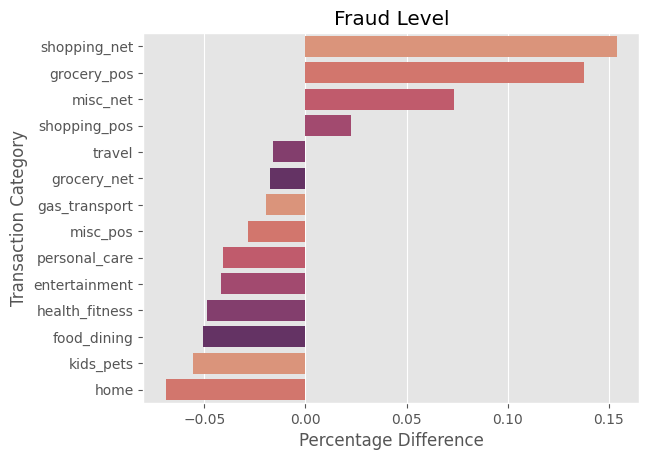

In [431]:
custom_palette = sns.color_palette("flare")
ax = sns.barplot(y='category', x='fraud_level',
                 data=non_fraud_vs_fraud.sort_values('fraud_level', ascending=False), palette=custom_palette)
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('Fraud Level');

As shown above, some categories are more propicious to have frauds than others.

Let's see how the Age distribution behaves for fraud and non-fraud transactions.

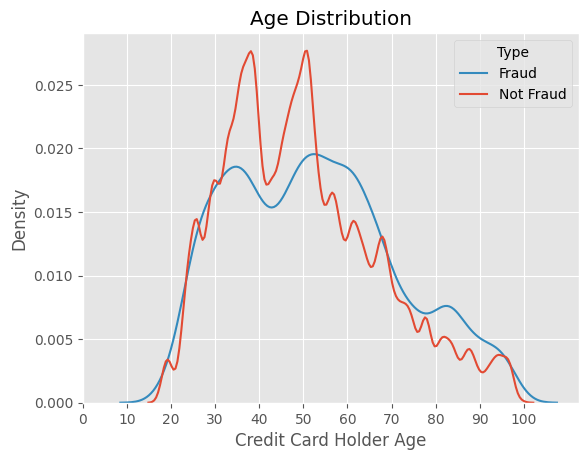

In [432]:
train['age'] = dt.date.today().year-pd.to_datetime(train['dob']).dt.year
ax = sns.kdeplot(x='age', data=train, hue='is_fraud', common_norm=False)
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.xticks(np.arange(0, 110, 10))
plt.title('Age Distribution')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud']);

We can observe that in non-fraudulent transactions, there is a peak around 35 years and 40 years, and another one around 50 years. On the other hand, in fraudulent operations, we observe a smoother distribution, with peaks around 35 years and in the range of 50 years to 55 years.

Let's analyze if the time in a day has any impact.

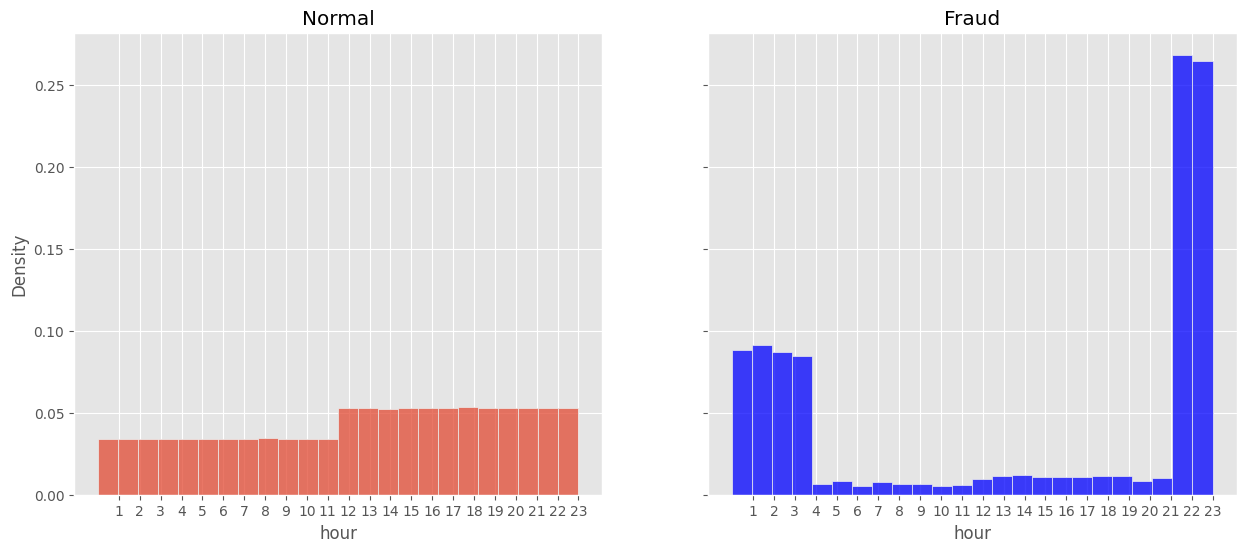

In [433]:
train['hour'] = pd.to_datetime(train['trans_date_trans_time']).dt.hour
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='hour', data=train[train["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1)
ax2 = sns.histplot(x='hour', data=train[train["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 24))
ax2.set_xticks(np.arange(1, 24));

As we can see, there is a clear pattern when it comes to hour in the day. Fraudulent payments happens more frequently around midnight than in normal transactions.

Let's do the same for months!

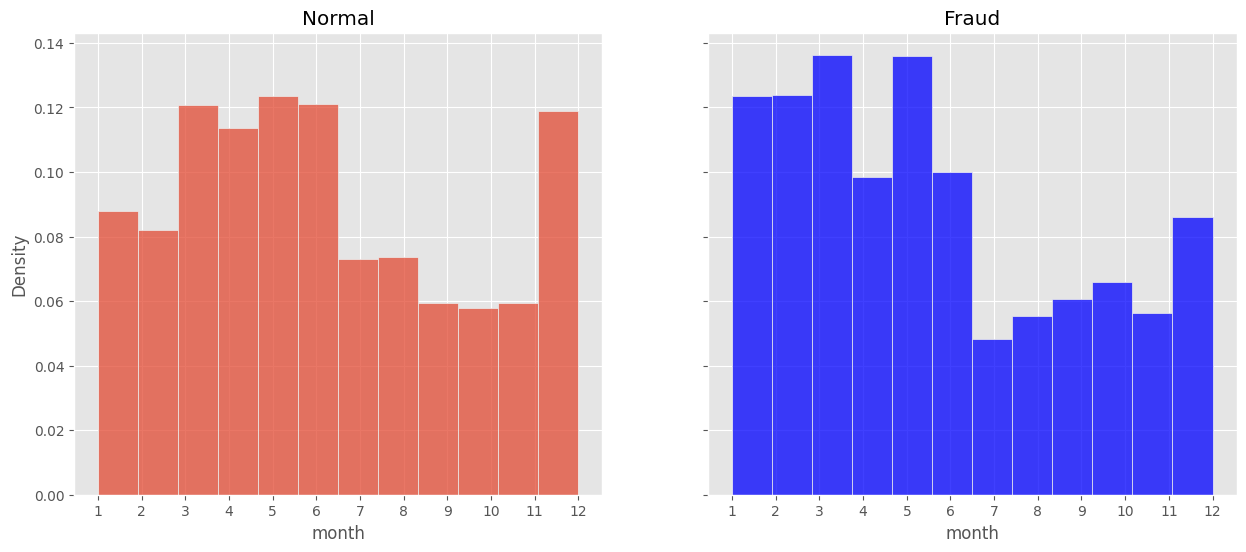

In [434]:
train['month'] = pd.to_datetime(train['trans_date_trans_time']).dt.month
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='month', data=train[train["is_fraud"] == 0],
                   stat="density", bins=12, ax=ax1)
ax2 = sns.histplot(x='month', data=train[train["is_fraud"] == 1],
                   stat="density", bins=12, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 13))
ax2.set_xticks(np.arange(1, 13));

# Feature Engineering

First, let's drop some columns that has duplicated or not useful information

In [435]:
train.drop(columns=["merchant", "first", "last", "street",
           "unix_time", "trans_num"], inplace=True)

In [436]:
train.head(2)

,trans_date_trans_time,cc_num,category,amt,gender,city,state,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,age,hour,month
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,36.01,-82.05,0,35,0,1
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,49.16,-118.19,0,45,0,1


We saw that the "amt" category has very little spacing between small numbers and large spacing between high numbers. Because of that, we are going to use non logarithm scaling, that increases the distance between small values and reduces de spacing between large ones.

## Scaling

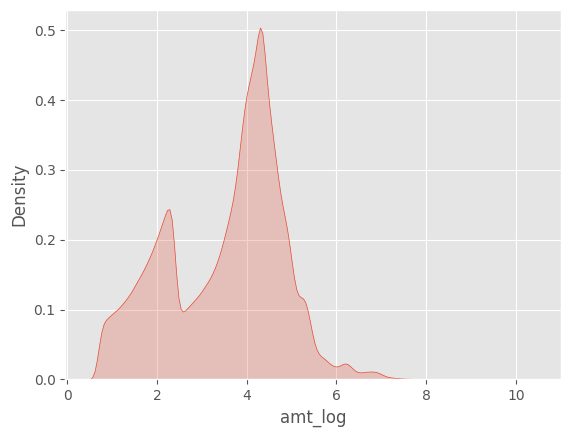

In [437]:
train["amt_log"] = np.log1p(train["amt"])
sns.kdeplot(train["amt_log"], fill=True);

Let's check the normality of the "amt" feature compared to its transformation "amt_log".

In [438]:
def check_normality(feature):
    plt.figure(figsize=(8, 8))
    ax1 = plt.subplot(1, 1, 1)
    stats.probplot(train[feature], dist=stats.norm, plot=ax1)
    ax1.set_title(f'{feature} Q-Q plot', fontsize=20)
    sns.despine()

    mean = train[feature].mean()
    std = train[feature].std()
    skew = train[feature].skew()
    print(f'{feature} : mean: {mean:.2f}, std: {std:.2f}, skew: {skew:.2f}')

amt : mean: 70.35, std: 160.32, skew: 42.28


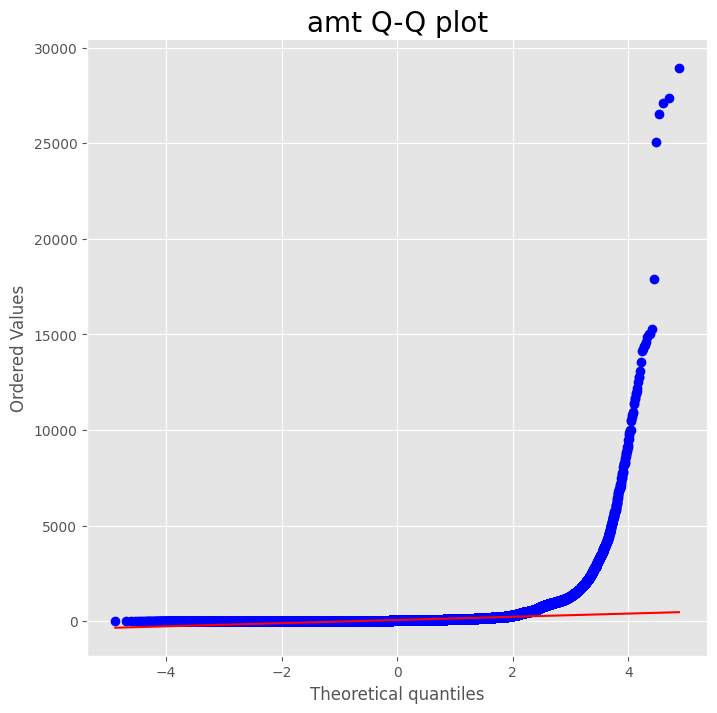

In [439]:
check_normality("amt");

amt_log : mean: 3.53, std: 1.29, skew: -0.30


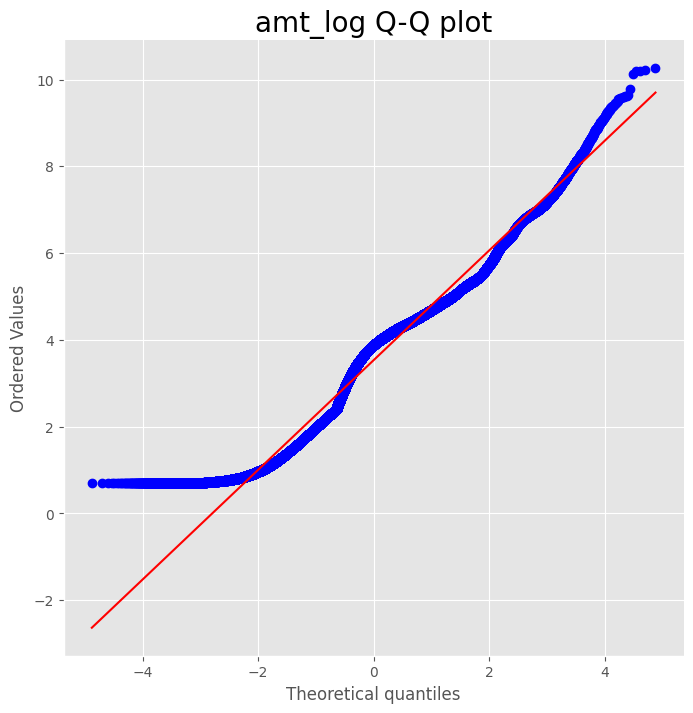

In [440]:
check_normality("amt_log");

We can see that with the logarithm scaling, the skewness has improved a lot.

## Categorical Encoding

Since we have a binary target and categorical variables with high cardinality, we are going to use the WOE (Weight of Evidence) encoder for the features: category, state, city and job.

In [441]:
def apply_woe(train, columns, target_col):
    woe = ce.WOEEncoder()

    for col in columns:
        X = train[col]
        y = train[target_col]

        new_col_name = f"{col}_WOE"
        train[new_col_name] = woe.fit_transform(X, y)

    return train


columns_to_encode = ["category", "state", "city", "job"]
target_column = "is_fraud"

train = apply_woe(train, columns_to_encode, target_column)

As for gender category, we can simply encode it by using dummies.

In [442]:
gender_mapping = {"F": 0, "M": 1}

train["gender_binary"] = train["gender"].map(gender_mapping)

We can encode the cc_num (credit card number) variable as well, by counting their frequencies in the database and them dividing them into classes, so we can classify the cards that are used a lot, and the ones that are not used often in the database.

In [443]:
freq_enc = (train.groupby("cc_num").size())
freq_enc.sort_values(ascending=True)
train["cc_num_frequency"] = train["cc_num"].apply(lambda x: freq_enc[x])

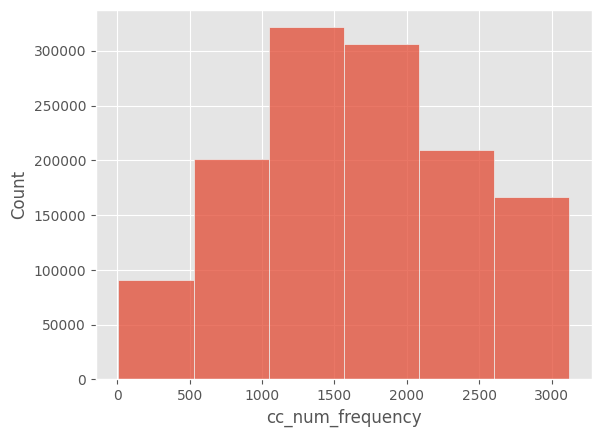

In [444]:
sns.histplot(train["cc_num_frequency"], bins=6);

In [445]:
intervals = [600, 1200, 1800, 2400, 3000, 3600]


def classify_frequency(freq):
    for i, c in enumerate(intervals):
        if freq <= c:
            return i


train["cc_num_frequency_classification"] = train["cc_num_frequency"].apply(
    classify_frequency)

Let's see if the distributions are different among the frequency classes for fraudulent and non-fraudulent transactions.

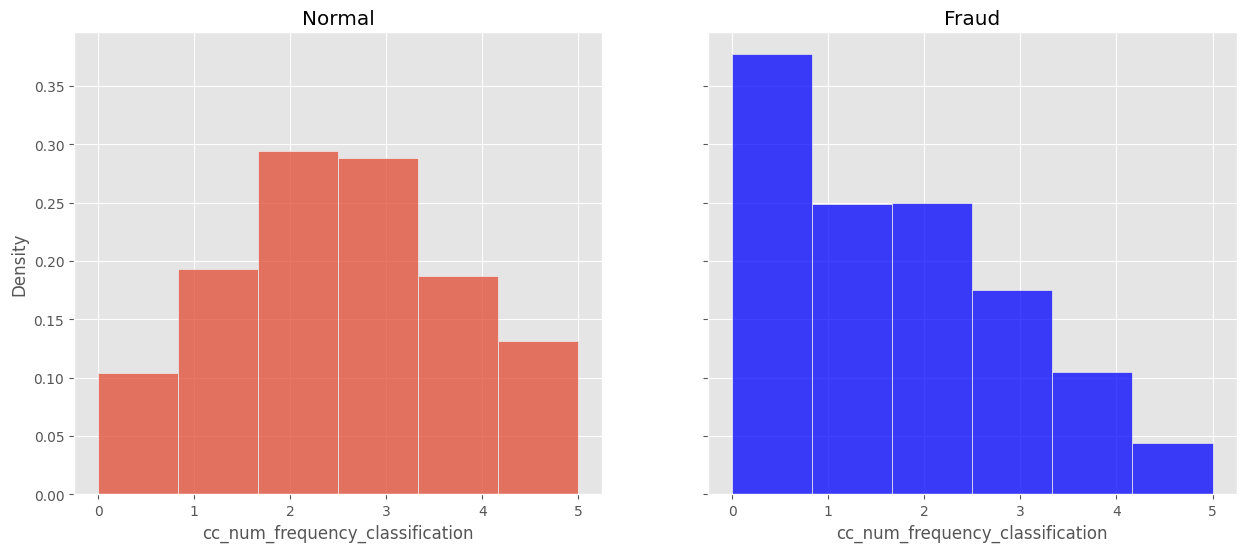

In [446]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='cc_num_frequency_classification', data=train[train["is_fraud"] == 0],
                   stat="density", bins=6, ax=ax1)
ax2 = sns.histplot(x='cc_num_frequency_classification', data=train[train["is_fraud"] == 1],
                   stat="density", bins=6, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud");

As we can see, there is a clear pattern happening. Frauds are more propitious to happen in credit cards with less use (new ones), and when it comes to normal transactions, it follows a normal distribution.

# Undersampling

As we saw, our data is very imbalanced. Because of that, we are going to use Undersampling in our favor. The method that we are going to use is the RandomUnderSampler.

In [447]:
X = train.drop(columns=["is_fraud"])
y = train["is_fraud"]

In [448]:
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=23)

In [449]:
X_undersampled, y_undersampled = rus.fit_resample(X, y)

Let's check our proportion after the Undersampling.

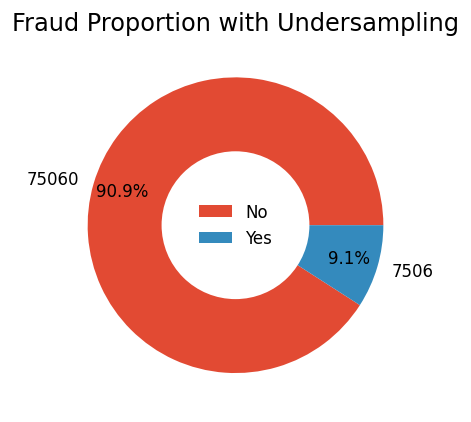

In [450]:
donut = y_undersampled.value_counts().reset_index()

labels = ["No", "Yes"]
explode = (0, 0)

fig, ax = plt.subplots(dpi=120, figsize=(8, 4))
plt.pie(donut["is_fraud"],
        labels=donut["is_fraud"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=explode)

centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Fraud Proportion with Undersampling")
plt.legend(labels, loc="center", frameon=False)
plt.show();

# Feature Importance

First, we are going to generate two random vectors to help us compare the feature importances (If a feature has less importance than a random vector, we can suspect that the feature is not good for the model).

In [451]:
X_undersampled["random_feat_1"] = np.random.randint(
    0, 100, size=len(X_undersampled))
X_undersampled["random_feat_2"] = np.random.randint(
    0, 500, size=len(X_undersampled))

In [452]:
X_train = X_undersampled.drop(columns=["trans_date_trans_time",
                                       "city", "state", "category", "gender", "dob", "job", "cc_num", "amt"])

y_train = y_undersampled

In [453]:
X_train.head()

,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,month,amt_log,category_WOE,state_WOE,city_WOE,job_WOE,gender_binary,cc_num_frequency,cc_num_frequency_classification,random_feat_1,random_feat_2
0,77566,29.04,-95.44,28739,29.24,-95.43,24,5,3,3.89,-0.21,-0.14,0.14,0.35,1,2556,4,31,150
1,12460,42.41,-74.15,277,41.56,-74.09,52,7,9,4.65,0.90,0.14,0.20,0.70,1,1548,2,72,270
2,98304,46.75,-121.99,759,46.60,-122.18,67,18,2,2.39,-0.70,-0.12,0.77,0.11,0,1040,1,28,213
3,31042,32.81,-83.17,1841,33.09,-84.14,48,5,10,3.63,-0.61,-0.03,0.00,-0.23,1,1548,2,54,364
4,99160,48.89,-118.21,149,48.08,-119.14,45,23,1,1.42,1.12,-0.12,-3.03,-0.90,0,3030,5,68,328


Let's use Boruta algorithm and random forests feature importances to identify which features we are going to use in our model.

In [454]:
rf = RandomForestClassifier(random_state=23, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state=999)
result_boruta = feat_selector.fit(X_train.values, y_train)
accept = X_train.columns[feat_selector.support_].to_list()
irresolution = X_train.columns[feat_selector.support_weak_].to_list()

print("Features selected:")
list(accept)

Features selected:


['zip',
 'lat',
 'long',
 'city_pop',
 'merch_lat',
 'merch_long',
 'age',
 'hour',
 'month',
 'amt_log',
 'category_WOE',
 'state_WOE',
 'city_WOE',
 'job_WOE',
 'gender_binary',
 'cc_num_frequency',
 'cc_num_frequency_classification']

Now let's check feature importance with Random Forest.

In [455]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
importances = rf.feature_importances_

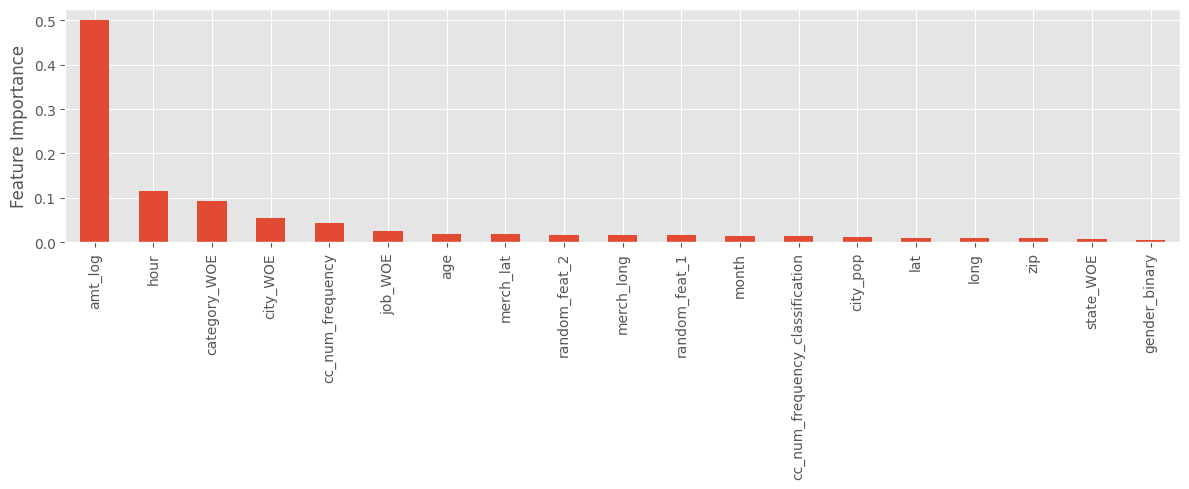

In [456]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(12, 5))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_ylabel("Feature Importance")
fig.tight_layout();

Now we proceed to select our features. Since "cc_num_frequency" and "cc_num_frequency_classification" is the same information, we are going to drop the less important.

In [457]:
X_train.drop(columns=["gender_binary", "state_WOE", "zip", "long", "lat",
                      "city_pop", "month", "cc_num_frequency_classification",
                      "random_feat_1", "random_feat_2", "merch_long"], inplace=True)

In [458]:
X_train.head()

,merch_lat,age,hour,amt_log,category_WOE,city_WOE,job_WOE,cc_num_frequency
0,29.24,24,5,3.89,-0.21,0.14,0.35,2556
1,41.56,52,7,4.65,0.90,0.20,0.70,1548
2,46.60,67,18,2.39,-0.70,0.77,0.11,1040
3,33.09,48,5,3.63,-0.61,0.00,-0.23,1548
4,48.08,45,23,1.42,1.12,-3.03,-0.90,3030


Finally, this is the features that are entering the model.

# Preparing test data

Let's apply the same transformations on test data.

In [459]:
test = pd.read_csv(r"data\fraudTest.csv", index_col=0)

test['age'] = dt.date.today().year-pd.to_datetime(test['dob']).dt.year
test['hour'] = pd.to_datetime(test['trans_date_trans_time']).dt.hour
test['month'] = pd.to_datetime(test['trans_date_trans_time']).dt.month

test.drop(columns=["merchant", "first", "last", "street",
                   "unix_time", "trans_num"], inplace=True)

test["amt_log"] = np.log1p(test["amt"])

test = apply_woe(test, columns_to_encode, target_column)

test["gender_binary"] = test["gender"].map(gender_mapping)

freq_enc_test = (test.groupby("cc_num").size())
freq_enc_test.sort_values(ascending=True)
test["cc_num_frequency"] = test["cc_num"].apply(lambda x: freq_enc_test[x])
test["cc_num_frequency_classification"] = test["cc_num_frequency"].apply(
    classify_frequency)

X_test = test.drop(columns=["trans_date_trans_time",
                            "city", "state", "category", "gender", "dob", "job", "cc_num", "amt", "is_fraud"])

y_test = test["is_fraud"]

X_test.drop(columns=["gender_binary", "state_WOE", "zip", "long", "lat",
                     "city_pop", "month", "cc_num_frequency_classification", "merch_long"], inplace=True)

# Preparing validation data

In order to tune our hyperparameters, we are going to separate our training set into training and validation.

In [460]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.2)

# Training the model

First, let's create a function to help us evaluate our models.

In [461]:
def evaluate_model(target, predicted, y_score, normalize_matrix= None):
    accuracy = metrics.accuracy_score(target, predicted)
    precision = metrics.precision_score(target, predicted)
    recall = metrics.recall_score(target, predicted)
    f1 = f1_score(target, predicted)
    auc = metrics.roc_auc_score(target, y_score)

    confusion_matrix = metrics.confusion_matrix(
        target, predicted, normalize=normalize_matrix)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=[False, True])
    cm_display.plot()
    plt.grid(False)
    plt.show()

    fpr, tpr, threshold = roc_curve(target, y_score)
    plt.plot(fpr, tpr, label="Model", c="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", c="yellow")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    print("Accuracy", accuracy.round(2))
    print("Precision:", precision.round(2))
    print("Recall:", recall.round(2))
    print("F1 Score", f1.round(2))
    print("AUC:", auc)
    return None

Now we'll run some tests on which models potentially runs best for our model!

In [462]:
rf = RandomForestClassifier(random_state=23)
knn = KNeighborsClassifier()
gboost = GradientBoostingClassifier(random_state=23)
lgbm = LGBMClassifier(random_state=23)

Let's see the results of the models without any tuning.

In [463]:
#random forest

rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_score_train = rf.predict_proba(X_train)[:,1]

y_pred_test = rf.predict(X_test)
y_score_test = rf.predict_proba(X_test)[:,1]

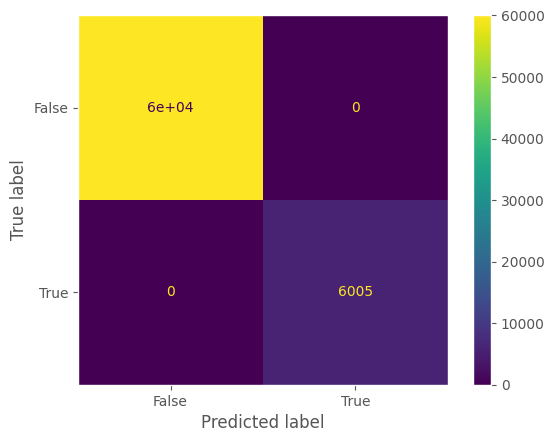

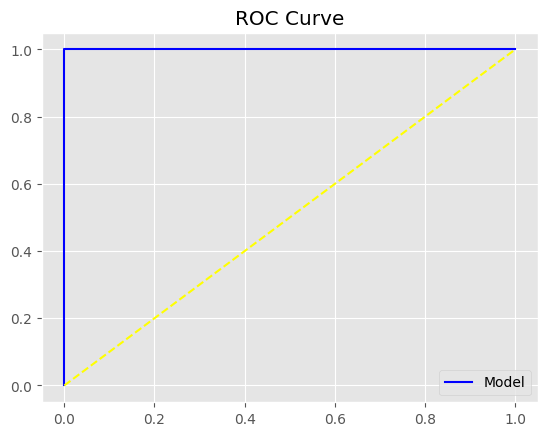

Accuracy 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0
AUC: 1.0


In [464]:
#training metrics
evaluate_model(y_train, y_pred_train, y_score_train)

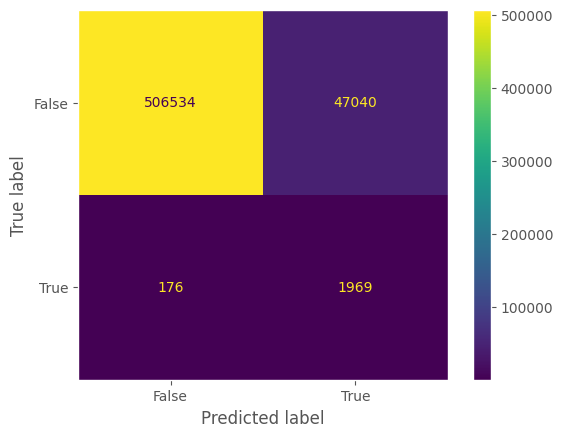

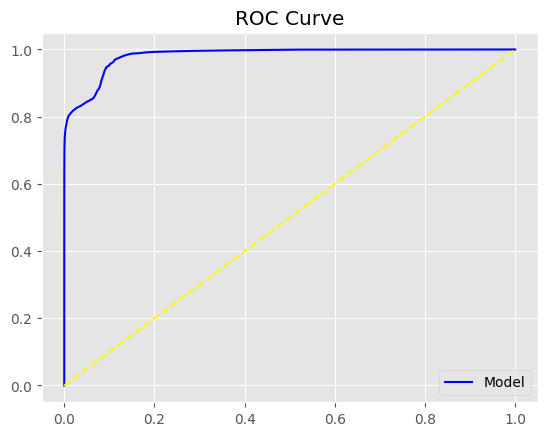

Accuracy 0.92
Precision: 0.04
Recall: 0.92
F1 Score 0.08
AUC: 0.9824525360412162


In [465]:
#test metrics
evaluate_model(y_test, y_pred_test, y_score_test)

In [466]:
#k-nearest neighbors

knn.fit(X_train, y_train)

y_pred_train = knn.predict(X_train)
y_score_train = knn.predict_proba(X_train)[:,1]

y_pred_test = knn.predict(X_test)
y_score_test = knn.predict_proba(X_test)[:,1]

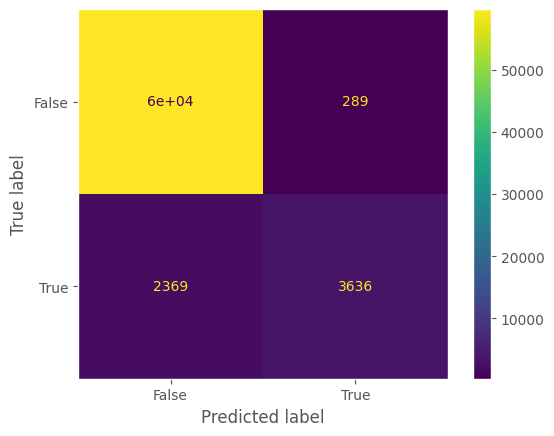

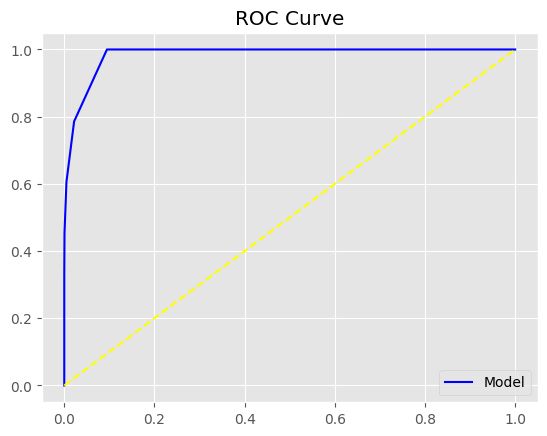

Accuracy 0.96
Precision: 0.93
Recall: 0.61
F1 Score 0.73
AUC: 0.9846854892892879


In [467]:
#training metrics
evaluate_model(y_train, y_pred_train, y_score_train)

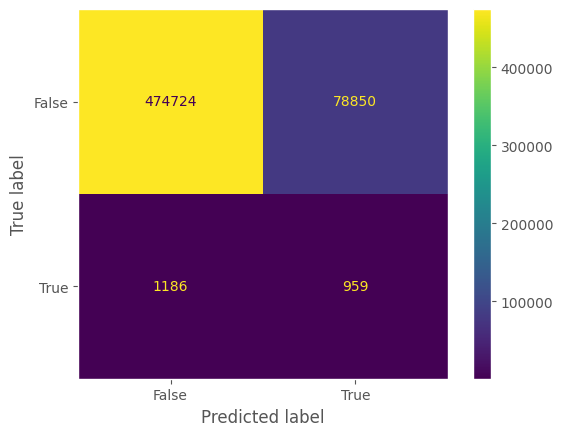

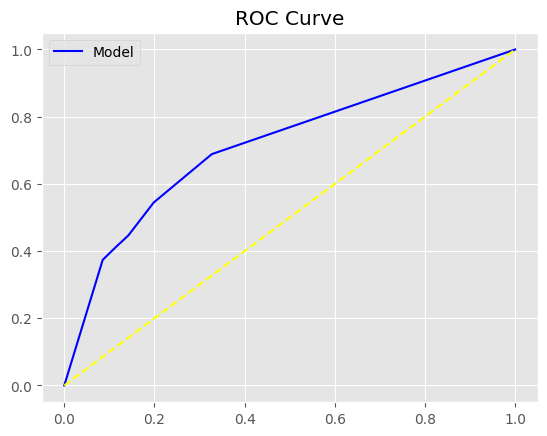

Accuracy 0.86
Precision: 0.01
Recall: 0.45
F1 Score 0.02
AUC: 0.7146315757365047


In [468]:
#test metrics
evaluate_model(y_test, y_pred_test, y_score_test)

In [469]:
#gradient boosting

gboost.fit(X_train, y_train)

y_pred_train = gboost.predict(X_train)
y_score_train = gboost.predict_proba(X_train)[:,1]

y_pred_test = gboost.predict(X_test)
y_score_test = gboost.predict_proba(X_test)[:,1]

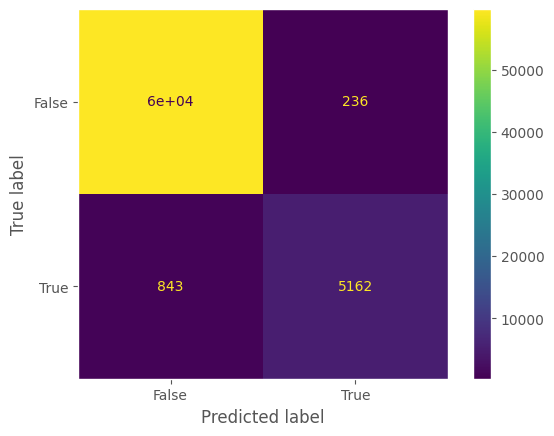

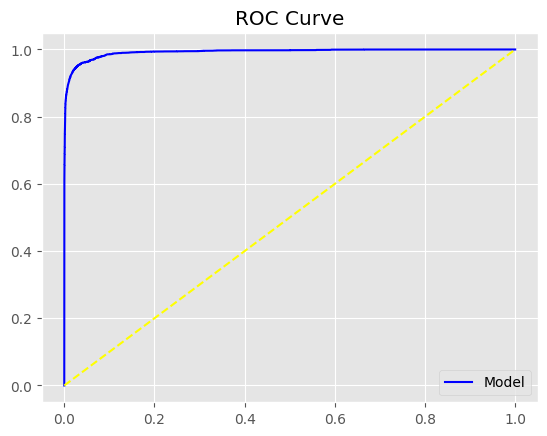

Accuracy 0.98
Precision: 0.96
Recall: 0.86
F1 Score 0.91
AUC: 0.9928279328569807


In [470]:
#training metrics
evaluate_model(y_train, y_pred_train, y_score_train)

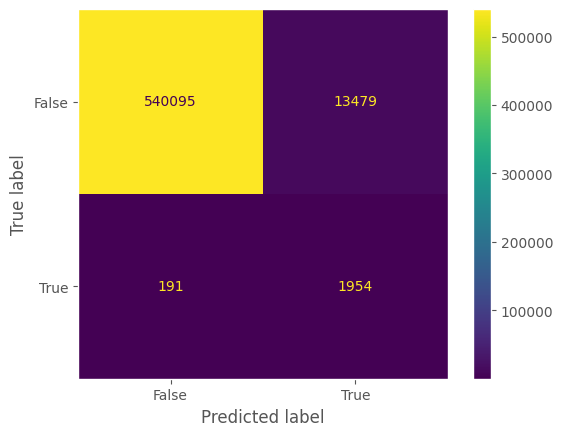

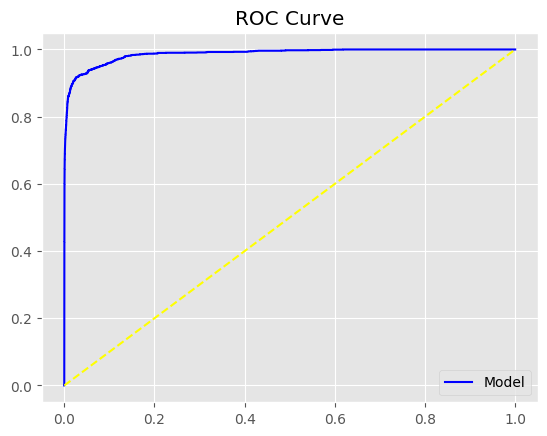

Accuracy 0.98
Precision: 0.13
Recall: 0.91
F1 Score 0.22
AUC: 0.9871646920305275


In [471]:
#test metrics
evaluate_model(y_test, y_pred_test, y_score_test)

In [472]:
#LightGBM

lgbm.fit(X_train, y_train)

y_pred_train = lgbm.predict(X_train)
y_score_train = lgbm.predict_proba(X_train)[:,1]

y_pred_test = lgbm.predict(X_test)
y_score_test = lgbm.predict_proba(X_test)[:,1]

[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535


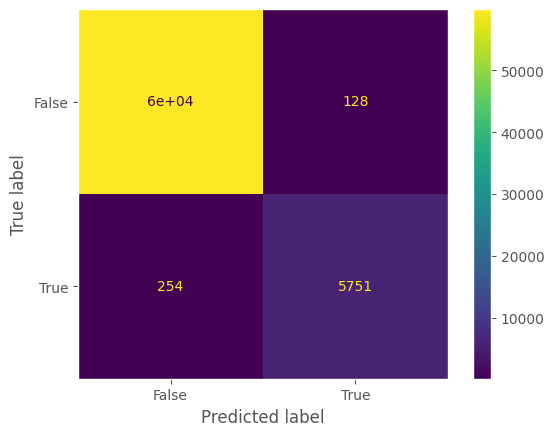

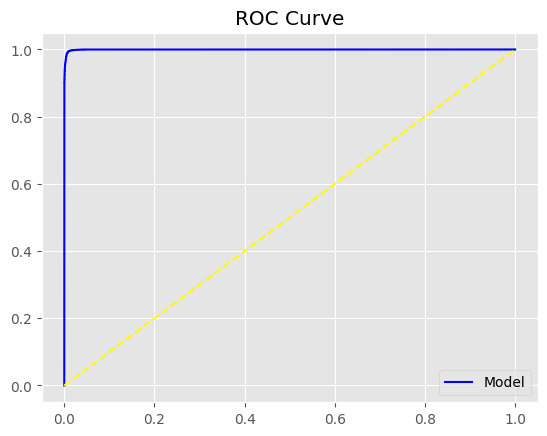

Accuracy 0.99
Precision: 0.98
Recall: 0.96
F1 Score 0.97
AUC: 0.9996603118841947


In [473]:
#training metrics
evaluate_model(y_train, y_pred_train, y_score_train)

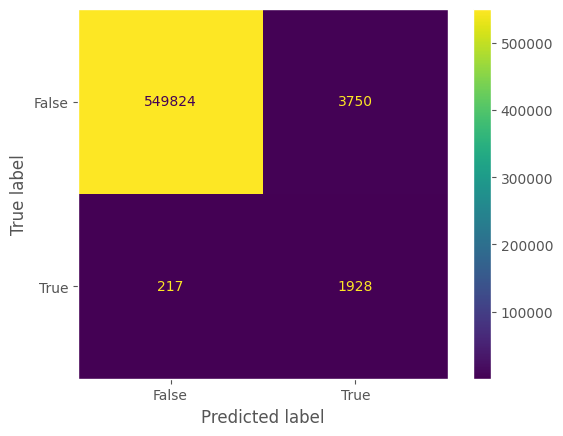

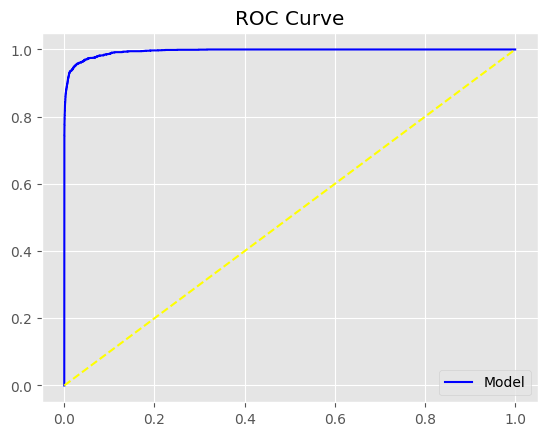

Accuracy 0.99
Precision: 0.34
Recall: 0.9
F1 Score 0.49
AUC: 0.9951145353638968


In [474]:
#test metrics
evaluate_model(y_test, y_pred_test, y_score_test)

LightGBM and GradientBoost performed really well on our model. So let's tune their parameters!

# Hyperparameter Tuning

In [475]:
def tune_lgbm(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params)
    
    mdl = LGBMClassifier(learning_rate= learning_rate,
                         num_leaves= num_leaves,
                         min_child_samples= min_child_samples,
                         subsample= subsample,
                         colsample_bytree= colsample_bytree,
                         random_state=23, subsample_freq=1,
                         n_estimators=200)
    
    mdl.fit(X_train, y_train)

    y_pred = mdl.predict(X_valid)
    
    return -metrics.f1_score(y_valid, y_pred)

In [476]:
space = [(1e-3, 1e-1, "log-uniform"), #learning_rate
        (2,128), #num_leaves
        (1,100), #min_child_samples
        (0.05, 1.0), #subsample
        (0.1, 1.0)] #colsample_bytree

In [482]:
results = gp_minimize(tune_lgbm, space, random_state=23,
                      verbose=1, n_calls=100, n_random_starts=20)

Iteration No: 1 started. Evaluating function at random point.
[0.021786840314037433, 25, 78, 0.5952129636704409, 0.4977223159193984]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.4171
Function value obtained: -0.8984
Current minimum: -0.8984
Iteration No: 2 started. Evaluating function at random point.
[0.002333405878539521, 15, 23, 0.8416721432755412, 0.4840888306663812]
[LightGBM] [Info] Number of positive: 6005, n

Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.3131
Function value obtained: -0.8783
Current minimum: -0.9402
Iteration No: 12 started. Evaluating function at random point.
[0.03486657777966428, 100, 97, 0.44192276574439365, 0.8162320161324087]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.8482
Function value obtained: -0.9345
Current minimum: -0.9402
Iteration No: 13 started. Eval

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [W

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.7862
Function value obtained: -0.0000
Current minimum: -0.9429
Iteration No: 23 started. Searching for the next optimal point.
[0.030071072340971877, 86, 99, 0.5858244349439156, 0.8469166172752793]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.9622
Function value obtained: -0.9398
Current minimum: -0.9429
Iteration No: 24 started. Searching for the next optimal point.
[0.0184814595949663

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.2353
Function value obtained: -0.9441
Current minimum: -0.9441
Iteration No: 44 started. Searching for the next optimal point.
[0.012368267984497706, 88, 1, 1.0, 0.8503106967502558]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.0552
Function value obtained: -0.9391
Current minimum: -0.9441
Iteration No: 45 started. Searching for the next optimal point.
[0.03237650088976637, 32, 100, 1.0,

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 1.0802
Function value obtained: -0.9259
Current minimum: -0.9455
Iteration No: 55 started. Searching for the next optimal point.
[0.019188537536729455, 128, 1, 1.0, 0.8540325071918026]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 1.2903
Function value obtained: -0.9453
Current minimum: -0.9455
Iteration No: 56 started. Searching for the next optimal point.
[0.09572352689370868, 119, 49, 1.0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 1.2823
Function value obtained: -0.9219
Current minimum: -0.9459
Iteration No: 72 started. Searching for the next optimal point.
[0.06016428590666185, 128, 100, 1.0, 0.3333130965957043]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 1.4993
Function value obtained: -0.9201
Current minimum: -0.9459
Iteration No: 73 started. Searchi

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 1.3503
Function value obtained: -0.9191
Current minimum: -0.9461
Iteration No: 83 started. Searching for the next optimal point.
[0.017781759298942955, 128, 1, 0.6018357395289703, 1.0]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 1.6634
Function value obtained: -0.9439
Current minimum: -0.9461
Iteration No: 84 started. Searching for the next optimal point.
[0.03202873309586103, 56, 100, 0.7

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 1.3743
Function value obtained: -0.9359
Current minimum: -0.9461
Iteration No: 92 started. Searching for the next optimal point.
[0.04094498341024825, 71, 100, 1.0, 0.7072727032944752]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 2.0545
Function value obtained: -0.9414
Current minimum: -0.9461
Iteration No: 93 started. Searching for the next optimal point.
[0.01569772461045668, 103, 1, 0.69

In [483]:
params = results.x
params

[0.017131406178440885, 128, 1, 1.0, 1.0]

In [484]:
learning_rate = params[0]
num_leaves = params[1]
min_child_samples = params[2]
subsample = params[3]
colsample_bytree = params[4]

In [485]:
#LightGBM
lgbm = LGBMClassifier(learning_rate= learning_rate,
                      num_leaves= num_leaves,
                      min_child_samples= min_child_samples,
                      subsample= subsample,
                      colsample_bytree= colsample_bytree,
                      random_state=23, subsample_freq=1,
                      n_estimators=200)

lgbm.fit(X_train, y_train)

y_pred_train = lgbm.predict(X_train)
y_score_train = lgbm.predict_proba(X_train)[:,1]

y_pred_test = lgbm.predict(X_test)
y_score_test = lgbm.predict_proba(X_test)[:,1]

[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535


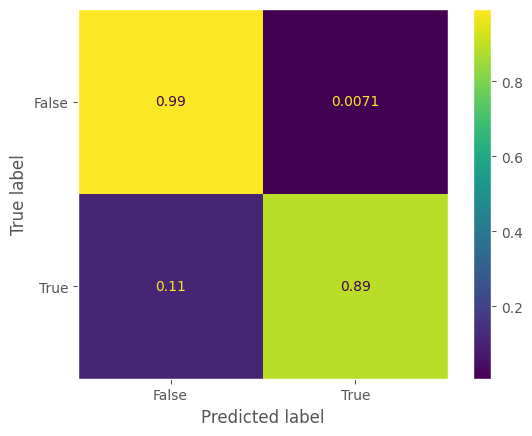

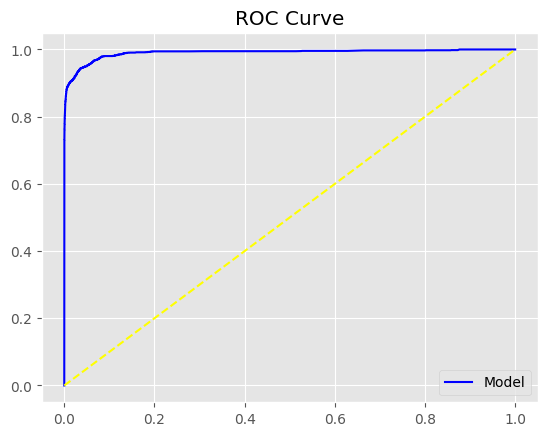

Accuracy 0.99
Precision: 0.33
Recall: 0.89
F1 Score 0.48
AUC: 0.9903116306570949


In [486]:
evaluate_model(y_test, y_pred_test, y_score_test, normalize_matrix="true")

# Conclusion

> In this problem, it is crucial to look at other metrics besides accuracy. As we saw, accuracy is one of the worst metrics for this problem, because of the natural imbalance of the dataset.

> Since our event is related to fraud transactions, i assume the worst cenarios was getting high false negatives (transactions that we identify as non-frauds and ended up being fraudulents). Hence, we used an aproach to consider the recall metric being the most important for the model.

> Also, the precision of the model is very sensitive, because of the target imbalance. As you can see, only 0.71% or normal transactions were false positives, and it dropped the precision to 33%. That is because a small percentage of normal transactions if predicted wrong, means a high number of events compared to the fraud events in dataset.

> The best approach to this problem would be having a way to calculate the mean cost of each false positive and false negative. This way, we could approach this tradeoff with better understanding of how much false positives and false negatives costs for the company.